# G4Hive MP performance analysis

Let's look at some measurements of G4Hive jobs for different number of AthenaMP worker processes and make some plots. We want to look at how memory and throughput scale with the number of workers.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatch
%matplotlib notebook

In [2]:
# Local imports
from utils.prep import parse_job_results, load_job_results
from utils.timing import (get_job_time, get_evloop_time,
                          get_initialization_time, get_finalization_time,
                          print_timing_summary,
                          get_throughput, get_avg_throughput,
                          calc_alg_timings, get_alg_duration_map)
from utils.memory import get_max_mem, get_mem_data

## Prepare the data 

The results come in the form of log files. A memory monitor runs alongside the job to measure its memory consumption as a function of time. The job also dumps a timeline log which shows the start and end times of every algorithm per thread and event slot. From these files we can extract everything we need.

In [3]:
results_dir = 'results_aibuild_ztt_mp'

In [4]:
ls $results_dir/

log.1_10_500.log        mem.1_10_500.csv        timeline.1_10_500.log
log.1_12_600.log        mem.1_12_600.csv        timeline.1_12_600.log
log.1_14_700.log        mem.1_14_700.csv        timeline.1_14_700.log
log.1_16_800.log        mem.1_16_800.csv        timeline.1_16_800.log
log.1_18_900.log        mem.1_18_900.csv        timeline.1_18_900.log
log.1_1_50.log          mem.1_1_50.csv          timeline.1_1_50.log
log.1_20_1000.log       mem.1_20_1000.csv       timeline.1_20_1000.log
log.1_22_1100.log       mem.1_22_1100.csv       timeline.1_22_1100.log
log.1_24_1200.log       mem.1_24_1200.csv       timeline.1_24_1200.log
log.1_28_1400.log       mem.1_28_1400.csv       timeline.1_28_1400.log
log.1_2_100.log         mem.1_2_100.csv         timeline.1_2_100.log
log.1_32_1600.log       mem.1_32_1600.csv       timeline.1_32_1600.log
log.1_3_150.log         mem.1_3_150.csv         timeline.1_3_150.log
log.1_4_200.log         mem.1_4_200.csv         timeline.1_4_200.log
log.1_5_250.log     

Parse the log files and get a list of JobResult objects

In [5]:
# Use a pre-processed pickle file
use_pickle = False

# Load or parse the results
if use_pickle:
    job_results = load_job_results(os.path.join(results_dir, 'results.pickle'))
else:
    job_results = parse_job_results(results_dir, verbose=False)

# Sort results by nProc instead of nThread
job_results.sort(key=lambda j: j.nProc)

Using results directory: results_aibuild_ztt_mp
54 total files
18 memory log files
18 timeline log files


In [6]:
# Prepare the alg timing results now
for job in job_results:
    calc_alg_timings(job)

## Job timing
Let's look at some general timing info about the jobs

In [7]:
print_timing_summary(job_results)

Procs Threads Events Job-time Init-time Loop-time Final-time
    1       1     50  19587.2     187.8   19396.4        3.1
    2       1    100  21316.3     196.3   21117.0        3.0
    3       1    150  21454.3     188.6   21260.7        5.0
    4       1    200  22035.1     196.8   21835.3        3.0
    5       1    250  21511.0     187.6   21320.5        2.9
    6       1    300  21653.2     176.6   21473.5        3.0
    7       1    350  22202.3     188.2   22011.1        3.1
    8       1    400  22315.5     238.3   22074.2        3.0
   10       1    500  22467.6     191.3   22273.3        2.9
   12       1    600  22600.2     192.1   22405.2        2.9
   14       1    700  22471.8     192.0   22276.8        3.1
   16       1    800  24706.8     227.5   24476.3        3.0
   18       1    900  25802.0     196.7   25602.1        3.2
   20       1   1000  28215.9     190.0   28022.8        3.1
   22       1   1100  30417.1     190.5   30223.5        3.1
   24       1   1200  32

Let's visualize the initialization and finalization times in plots.

In [8]:
init_times = [get_initialization_time(j) for j in job_results]
final_times = [get_finalization_time(j) for j in job_results]
nProcs = np.array([j.nProc for j in job_results])

<IPython.core.display.Javascript object>


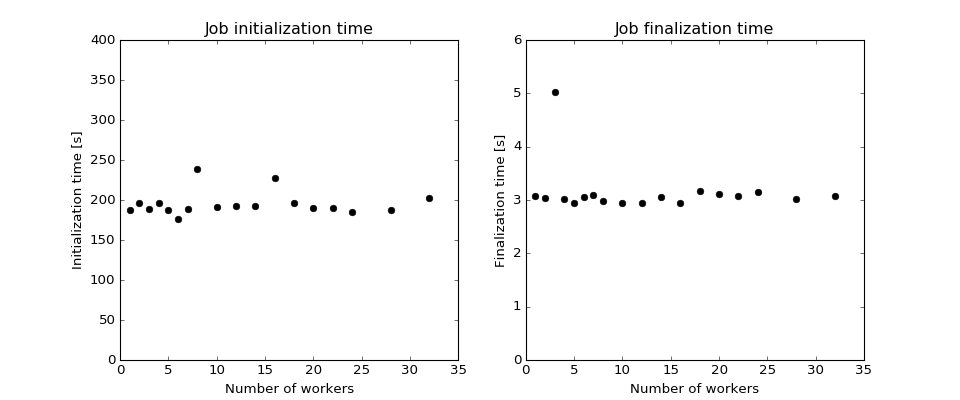

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(nProcs, init_times, 'ko')
plt.title('Job initialization time')
plt.ylim(ymin=0, ymax=400)
plt.xlabel('Number of workers')
plt.ylabel('Initialization time [s]')
plt.subplot(122)
plt.plot(nProcs, final_times, 'ko')
plt.title('Job finalization time')
plt.ylim(ymin=0, ymax=6)
plt.xlabel('Number of workers')
plt.ylabel('Finalization time [s]');

## Event throughput

Event throughput is arguably the most important result, so let's see how it scales with the number of threads. We calculate it by considering only the time in the event loop and the number of events processed. Then ideally the throughput should scale linearly with the number of threads

<IPython.core.display.Javascript object>


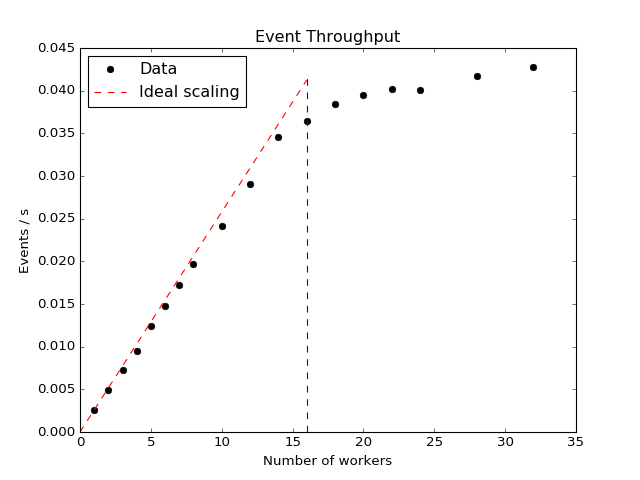

In [10]:
thruPuts = np.array([get_avg_throughput(j) for j in job_results])
plt.figure()
plt.title('Event Throughput')
plt.plot(nProcs, thruPuts, 'ko', label='Data')
plt.xlabel('Number of workers')
plt.ylabel('Events / s')
#plt.ylim(ymin=0, ymax=0.004)

# Draw ideal-scaling line, assuming 1-thread job as baseline
num_cores = 16
ideal_threads = np.array([0, num_cores])
ideal_thruput = ideal_threads * thruPuts[0]
plt.plot(ideal_threads, ideal_thruput, '--r', label='Ideal scaling')

# Draw vertical line at number of physical cores
cores_x, cores_y = [num_cores, num_cores], [0, 0.042]
plt.plot(cores_x, cores_y, '--b')

plt.legend(loc=2, numpoints=1);

## Memory scaling

Start with some helper functions for memory calculations, then plot memory footprint as a function of number of threads, as well as the memory in each job as a function of time.

<IPython.core.display.Javascript object>


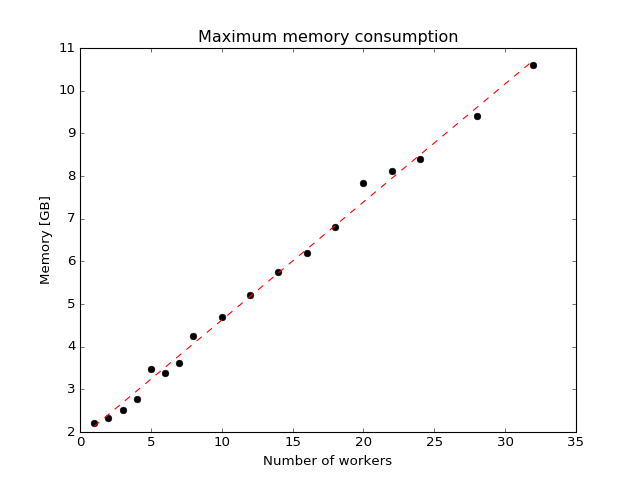

Memory fit: 1.85 GB + 276.81 MB/thread


In [11]:
maxMems = np.array([get_max_mem(j) for j in job_results])

# Fit a line to the data
fit = np.polyfit(nProcs, maxMems, 1)
fit_fn = np.poly1d(fit)

plt.figure()
plt.title('Maximum memory consumption')
plt.plot(nProcs, maxMems, 'ko', nProcs, fit_fn(nProcs), '--r')
plt.xlabel('Number of workers')
plt.ylabel('Memory [GB]')

print('Memory fit: {0:.2f} GB + {1:.2f} MB/thread'.format(fit[1], fit[0]*1e3))

<IPython.core.display.Javascript object>


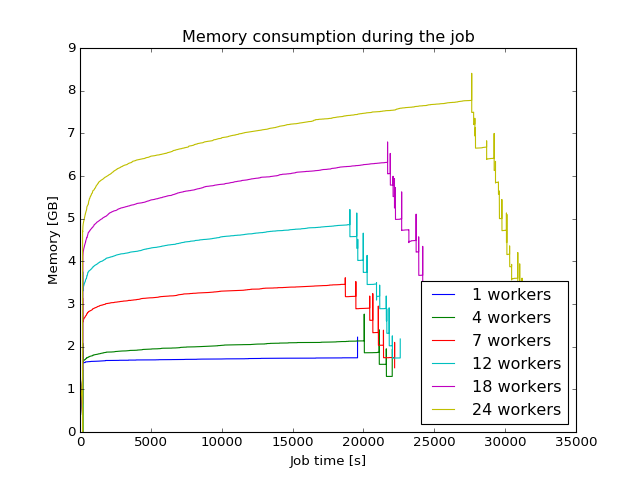

In [12]:
# Show memory as a function of job time
plt.figure()
plt.title('Memory consumption during the job')
for j in job_results[::3]:
    label = '%i workers' % j.nProc
    times, mems = get_mem_data(j)
    # Last point is sometimes iffy, so I exclude it
    plt.plot(times[:-1], mems[:-1], label=label)
plt.xlabel('Job time [s]')
plt.ylabel('Memory [GB]')
plt.legend(loc=4);

## Algorithm analysis

G4Hive currently has four algorithms:
* SGInputLoader populates the whiteboard with initial data
* BeamEffectsAlg applies some smearing effects to the generated event
* G4AtlasAlg runs Geant4 simulation on the smeared generated event
* StreamHITS writes the hit collections to output

Let's take a look at how the job breaks down by algorithm. We'd like to know how much time is spent in each algorithm and the timing distributions look for each alg.

Let's start with histograms of the duration of each algorithm. I want to see how the alg-time distribution varies with number of threads. I suspect the algorithms are taking longer with more threads because of some lock contention.

In [13]:
alg_duration_maps = [get_alg_duration_map(j) for j in job_results]
g4alg_times = np.array([m['G4AtlasAlg'] for m in alg_duration_maps])
loaderalg_times = np.array([m['SGInputLoader'] for m in alg_duration_maps])
streamalg_times = np.array([m['StreamHITS'] for m in alg_duration_maps])
beamalg_times = np.array([m['BeamEffectsAlg'] for m in alg_duration_maps])

In [15]:
nProcs

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 12, 14, 16, 18, 20, 22, 24, 28,
       32])

<IPython.core.display.Javascript object>


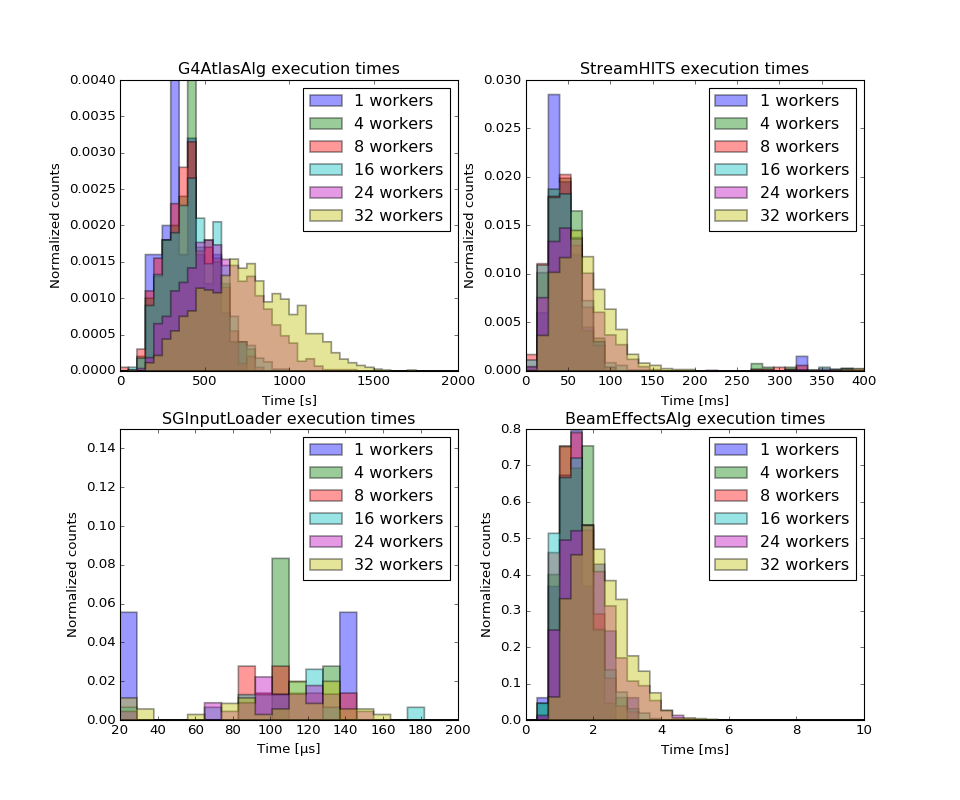

In [16]:
# Plot the histograms
plt.figure(figsize=(12, 10))

common_args = {'histtype': 'stepfilled',
               'alpha' : 0.4, 'linewidth' : 1.5,
               'normed' : True}

idxs = np.array([0, 3, 7, 11, 15, 17])

# The G4AtlasAlg timings
plt.subplot(221)
plt.title('G4AtlasAlg execution times')
for proc, times in zip(nProcs[idxs], g4alg_times[idxs]):
    label = '{0:d} workers'.format(proc)
    plt.hist(times, bins=40, range=(0,2000), label=label, **common_args)
plt.xlabel('Time [s]')
plt.ylabel('Normalized counts')
#plt.ylim(0, 0.007)
plt.legend()

# The StreamHITS timings
plt.subplot(222)
plt.title('StreamHITS execution times')
#skip=4
for proc, times in zip(nProcs[idxs], streamalg_times[idxs]):
    label = '{0:d} workers'.format(proc)
    plt.hist(times*1e3, bins=30, range=(0,400), label=label, **common_args)
plt.xlabel('Time [ms]')
plt.ylabel('Normalized counts')
#plt.ylim(0, 0.04)
plt.legend()

# The SGInputLoader timings
plt.subplot(223)
plt.title('SGInputLoader execution times')
#skip=10
for proc, times in zip(nProcs[idxs], loaderalg_times[idxs]):
    label = '{0:d} workers'.format(proc)
    plt.hist(times*1e6, bins=20, range=(20,200), label=label, **common_args)
plt.xlabel('Time [µs]')
plt.ylabel('Normalized counts')
plt.ylim(0, 0.15)
plt.legend()

# The BeamEffectsAlg timings
plt.subplot(224)
plt.title('BeamEffectsAlg execution times')
#skip=4
for proc, times in zip(nProcs[idxs], beamalg_times[idxs]):
    label = '{0:d} workers'.format(proc)
    plt.hist(times*1e3, bins=30, range=(0,10), label=label, **common_args)
plt.xlabel('Time [ms]')
plt.ylabel('Normalized counts')
plt.legend();

For the next plot, I want to show how the total time in the event loop is broken down into algorithms and non-algorithmic time, where the latter includes scheduler overhead and waiting time. I think a stacked bar graph will service nicely here. Let's sum times across threads but normalize to the number of events. The total sum then is the inverse of the throughput.

Ok, so how do I get these results? I will likely want to break down the numbers in terms of each algorithm. I may need to restructure how I do the histograms above and the timeline below to reduce the amount of code and computation.

In [17]:
# A color map for the algorithms
alg_color_map = {'SGInputLoader' : 'yellow',
                 'BeamEffectsAlg' : 'blue',
                 'G4AtlasAlg' : 'red',
                 'StreamHITS' : 'green',
                 #'AthOutSeq' : 'yellow',
                 #'AthRegSeq' : 'purple',
                }

def get_time_sum_map(job_results, alg_duration_maps):
    """For each job, calculate the total time spent in each alg.
    Normalize by the number of events and organize the results
    into a list per alg in a dict."""
    time_sum_map = {}
    for j, dur_map in zip(job_results, alg_duration_maps):
        total_alg_time = 0.
        for alg, durs in dur_map.items():
            alg_time = durs.sum() / j.nEvent
            time_sum_map.setdefault(alg, []).append(alg_time)
    return time_sum_map

In [18]:
# Get the map of summed alg times
time_sum_map = get_time_sum_map(job_results, alg_duration_maps)
# Get the normalized total time in each job
total_time_sums = [get_evloop_time(j)*j.nProc/j.nEvent for j in job_results]

<IPython.core.display.Javascript object>


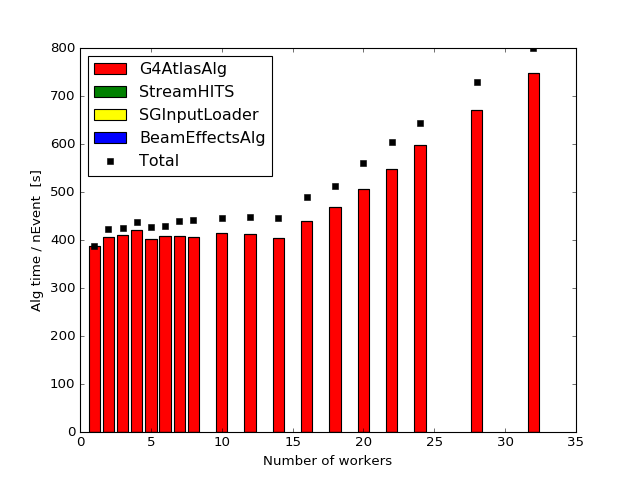

In [19]:
plt.figure()
algs = ['G4AtlasAlg', 'StreamHITS', 'SGInputLoader', 'BeamEffectsAlg']
colors = [alg_color_map[alg] for alg in algs]
leg_items = []
# Do the first one
x = plt.bar(nProcs, time_sum_map[algs[0]], color=colors[0], align='center')
leg_items.append(x[0])
# Do the rest
for i in range(1, len(algs)):
    x = plt.bar(nProcs, time_sum_map[algs[i]],
                bottom=time_sum_map[algs[i-1]],
                color=colors[i], align='center')
    leg_items.append(x[0])
x = plt.plot(nProcs, total_time_sums, 'sk', label='Total')
plt.ylabel('Alg time / nEvent  [s]')
plt.xlabel('Number of workers')
plt.legend(leg_items + [x[0]], algs + ['Total'], loc=2, numpoints=1);

## Event loop timeline

For the timeline plot, we'll split the results by thread in a bar graph.

In [25]:
class TimelineThreadData():
    """Simple struct for holding relevant timeline data in one thread"""
    def __init__(self, tid):
        self.tid = tid

def get_timeline_thread_data(job):
    """Get the processed timeline results per thread"""
    # Get the unique thread IDs
    tids = j.timeline_results['tids']
    unique_tids = np.unique(tids)
    assert(len(unique_tids) == (j.nThread * j.nProc)) # sanity check
    # Create and fill the per-thread timeline data
    ttds = [TimelineThreadData(tid) for tid in unique_tids]
    for ttd in ttds:
        indices = tids == ttd.tid
        algs = j.timeline_results['algs'][indices]
        ttd.colors = np.array([alg_color_map.get(alg, 'black') for alg in algs])
        starts = j.alg_starts[indices]
        durations = j.alg_durations[indices]
        ttd.times = np.column_stack((starts, durations))
    return ttds

In [30]:
# For the timeline plot, we'll look at just one job for now
j = job_results[11]
print(j.nProc)

# Prepare timeline data split by thread ID
tldata_by_thread = get_timeline_thread_data(j)
unique_tids = np.unique(j.timeline_results['tids'])

16


<IPython.core.display.Javascript object>


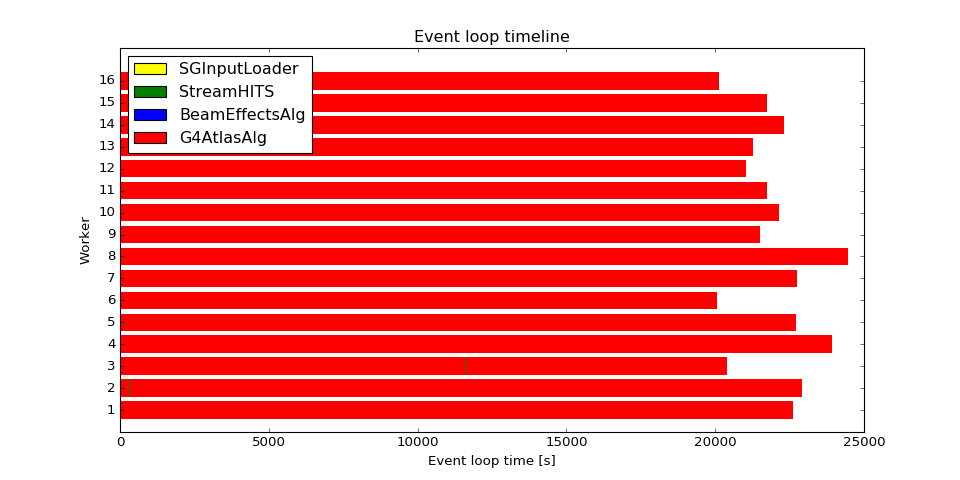

In [31]:
# Prepare the plot
plt.figure(figsize=(12, 6))
plt.title('Event loop timeline')
bar_thickness = 0.8
for i, tldata in enumerate(tldata_by_thread):
    ylow = (i + 1.) - bar_thickness/2
    plt.broken_barh(tldata.times, [ylow, bar_thickness], facecolors=tldata.colors, linewidth=0)
# Fake bar objects to populate the legend
legbars = [mpatch.Rectangle((0, 0), 1, 1, fc=c) for c in alg_color_map.values()]
plt.xlabel('Event loop time [s]')
plt.ylabel('Worker')
plt.yticks(range(1, len(unique_tids)+1))
plt.ylim(ymax=len(unique_tids)+1.5)
plt.xlim(xmin=0)
#plt.xlim(9, 9.1)
plt.legend(legbars, alg_color_map.keys(), loc=2);